# User Uploaded Tables
<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
Contact authors: Yumi Choi <br>
Last verified to run: 2024-06-03 <br>
LSST Science Piplines version: Weekly 2024_16 <br>
Container Size: small <br>
Targeted learning level: Beginner <br>

**Description:** Use the TAP upload functionality for user-supplied tables and join them with DP0.3 catalogs.

**Skills:** Use the TAP service to upload a table and join it to an LSST table with ADQL.

**LSST Data Products:** TAP tables dp03_catalogs_10yr.SSObject, dp03_catalogs_10yr.MPCORB, dp03_catalogs_10yr.DiaSource

**Packages:** lsst.rsp.get_tap_service

**Credit:**
Developed by Yumi Choi. This tutorial is based on <a href="https://dp0-3.lsst.io/tutorials-dp0-3/portal-dp0-3-5.html">a Portal tutorial</a> by Christina Williams for using user-supplied tables in queries for DP0.3 and <a href="https://github.com/rubin-dp0/cst-dev/blob/main/MLG_sandbox/DP03/gaia_hack_day_Feb2024.ipynb">a Jupyter Notebook</a> by Melissan Graham and Jake Kurlander for accessing Gaia data and matching with DP0.3 data for solar system objects.

**Get Support:** Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook illustrates the process of uploading user-provided tables via the TAP service and integrating them into queries for DP0.3. It focuses on two types of user-provided tables: (1) tables generated outside the RSP, and (2) tables created within the RSP but retrieved from an external database using [PyVO](https://github.com/astropy/pyvo).

### 1.1. Import packages

Import general python packages and the Rubin Table Access Protocol (TAP) service.

[PyVO](https://pyvo.readthedocs.io/en/latest/) is a package providing access to remote data and services of the Virtual observatory (VO) using Python.

In [75]:
import os
import getpass
import matplotlib.pyplot as plt
import numpy as np
import pyvo
from astropy.table import Table
import pandas as pd
from lsst.rsp import get_tap_service

### 1.2. Define parameters

Set a few style parameters for the plots.

In [2]:
plt.style.use('tableau-colorblind10')
params = {'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 10}
plt.rcParams.update(params)

Define the path to the home directory, where outputs generated by this tutorial will be saved.

In [3]:
my_home_dir = '/home/' + getpass.getuser() + '/'
print(my_home_dir)

/home/galaxyumi331/


Start the TAP service and assert that it exists.

In [4]:
rsp_tap = get_tap_service("ssotap")
assert rsp_tap is not None

## 2. Spatial and temporal cross-match to diaSources

The scientific scenario used for this demonstration is to answer the question
of whether LSST detected a moving object which, based on its known orbit, was
expected to appear at given coordinates on nine different nights.

The list of expected coordinates and dates is provided in a file with nine rows
(i.e., nine expected locations and times), with the format
expected for user-uploaded tables: column names in the first row with no # symbol at the start of the row.
The list contains columns of identifier index, right ascension, declination, and modified julian date (id, ra, dec, and mjd).

The [ADQL](https://www.ivoa.net/documents/ADQL/) query below uploads this list to the TAP service and cross-matches to
the table of detected sources that results from difference image analysis: the `diaSource` table
(learn more about [DP0.3 catalogs](https://dp0-3.lsst.io/data-products-dp0-3/index.html#dp0-3-data-products-definition-document-dpdd)).

In [5]:
fnm1 = 'data/dp03_06_user_table_1.cat'

**Option:** View the contents of the file with `more`, or return the word count (lines, words, characters) with `wc`.

In [6]:
# os.system('more ' + fnm1)
# os.system('wc ' + fnm1)

::::::::::::::
data/dp03_06_user_table_1.cat
::::::::::::::
id	ra	dec	mjd
0	314.9407129	-31.5520653	62800.04496
1	338.0151274	-14.4770618	61741.04101
2	22.8351124	13.0273351 	63450.38788
3	352.2623818	-13.4892628	61632.24295
4	349.8507502	-14.3276051	61644.29927
5	338.014364	-14.4779895	61741.02776
6	317.6805893	-35.8352626	61291.0246
7	345.2016394	-15.5920336	61665.05291
8	324.1765195	-35.9475313	61267.33191

0

Read the file as user table 1, `ut1`.

In [7]:
ut1 = Table.read(fnm1, format='ascii.basic')

Define a query to cross match the coordinates
and dates in the file to detections in the DP0.3 `diaSource` catalog.

This query is applying a spatial threshold of 10 arcseconds (0.00278 degrees), and a temporal threshold of half a day.

Notice that the columns from the user-uploaded table are being renamed in the query, e.g., `ut1.ra AS ut1_ra`.
If this renaming is not done, the TAP service will rename the columns from the user table as `ra2` and `dec2`
to distinguish them from the `ra` and `dec` columns from the `DiaSource` table.

In [8]:
query = """
        SELECT dias.ra, dias.dec, dias.midPointMjdTai, dias.ssObjectId,
        ut1.ra AS ut1_ra, ut1.dec AS ut1_dec, ut1.mjd AS ut1_mjd, ut1.id AS ut1_id
        FROM dp03_catalogs_10yr.DiaSource AS dias, TAP_UPLOAD.ut1 AS ut1
        WHERE CONTAINS(POINT('ICRS', dias.ra, dias.dec),
        CIRCLE('ICRS', ut1.ra, ut1.dec, 0.00278))=1
        AND ABS(dias.midPointMjdTai - ut1.mjd) < 0.5
        ORDER BY dias.ssObjectId
        """

Create the job by submitting the query and then run it asynchronously.

In [9]:
job = rsp_tap.submit_job(query, uploads={"ut1": ut1})
job.run()

Check that the job is completed.

In [10]:
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


Retrieve the results and display them.

In [11]:
results = job.fetch_result().to_table()
results

ra,dec,midPointMjdTai,ssObjectId,ut1_ra,ut1_dec,ut1_mjd,ut1_id
deg,deg,d,,,,,
float64,float64,float64,int64,float64,float64,float64,int64
314.9407129,-31.5520653,62800.04496,2956589648411852100,314.9407129,-31.5520653,62800.04496,0
314.939805,-31.5544472,62800.02065,2956589648411852100,314.9407129,-31.5520653,62800.04496,0
338.0151274,-14.4770618,61741.04101,2956589648411852100,338.0151274,-14.4770618,61741.04101,1
338.014364,-14.4779895,61741.02776,2956589648411852100,338.0151274,-14.4770618,61741.04101,1
22.8351124,13.0273351,63450.38788,2956589648411852100,22.8351124,13.0273351,63450.38788,2
352.2623818,-13.4892628,61632.24295,2956589648411852100,352.2623818,-13.4892628,61632.24295,3
349.8507502,-14.3276051,61644.29927,2956589648411852100,349.8507502,-14.3276051,61644.29927,4
349.8505526,-14.3276598,61644.30017,2956589648411852100,349.8507502,-14.3276051,61644.29927,4


In the table above, notice that the `ssObjectId` is all the same.
This is because the file was created to contain the detections of a single moving object across multiple nights.

Notice also that whereas the user-uploaded table had 9 rows, there are 15 matches to the `diaSource` table.
Six of the rows had two matches.
This means that six times, this moving object was detected twice within 10 arcseconds in the same night.

### 2.1. Plot the spatial and temporal offsets

For the purposes of demonstrating some kind of plot out of the results of this cross-matching, calculate the spatial and temporal
offsets (`s_off` and `t_off`) between the detected `diaSource`s and the user uploaded expectations,
and then plot the spatial vs. the temporal offsets.

In [12]:
cos_dec = np.cos(np.deg2rad(results['dec']))
delta_ra = cos_dec * np.abs(results['ra'] - results['ut1_ra'])
delta_dec = np.abs(results['dec'] - results['ut1_dec'])
s_off = 3600.0 * np.sqrt(delta_ra**2 + delta_dec**2)
t_off = 24.0 * 60.0 * np.abs(results['midPointMjdTai'] - results['ut1_mjd'])
del cos_dec, delta_ra, delta_dec

Moving objects do not exhibit a constant rate of motion on the sky in terms of, e.g., arcsec per minute,
but a correlation between spatial and temporal offset is expected.
Keep in mind that nine of these points will be at zero (no offset; perfect match).
But for the six additional, newly-discovered detections in
the `diaSource` catalog which were not in the user-uploaded table,
there should be larger spatial offsets for larger temporal offsets.

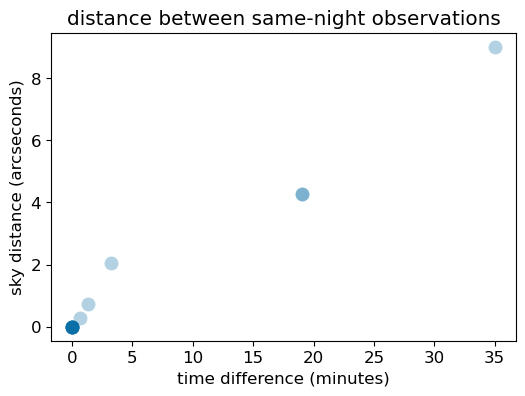

In [26]:
fig = plt.figure(figsize=(6, 4))
plt.plot(t_off, s_off, 'o', ms=10, alpha=0.3, mew=0)
plt.xlabel('time difference (minutes)')
plt.ylabel('sky distance (arcseconds)')
plt.title('distance between same-night observations')
plt.show()

> Figure 1: Above, the sky distance in arcseconds is plotted versus the time difference in minutes for the 15 detections cross-matched with the 9 anticipated coordinates and times in the user-uploaded table.

Clean up.

In [27]:
del t_off, s_off
del fnm1, ut1, query, job, results

## 3. Object identifier cross-match to diaSources

This section demonstrates how to upload a user-supplied table and join it with a DP0.3 table.

In this scenario, a list of identifiers (`ssObjectId`) for moving objects has been assembled
by the user and stored in a file (one column, two rows of data).

As in Section 2, define the file name, optionally print the contents or the word count, 
and then read in the file.

In [28]:
fnm2 = 'data/dp03_06_user_table_2.cat'

In [30]:
# os.system('more ' + fnm2)
# os.system('wc ' + fnm2)

In [31]:
ut2 = Table.read(fnm2, format='ascii.basic')

Define a query to use an inner join on the user-uploaded table and the `diaSource` table
to return only records (objects) that have matching values in both tables.

**Inner join:** An inner join is the default type of join, and is what is done if simply `JOIN` is used in a query.
Other types of joins include outer joins (e.g., left, right, full) which optionally return
all records in one or the other table, with matches where available.

In [32]:
query = """
        SELECT ut2.ssObjectId_user, dias.ssObjectId, dias.ra, dias.dec
        FROM TAP_UPLOAD.ut2 as ut2
        INNER JOIN dp03_catalogs_10yr.diaSource as dias
        ON ut2.ssObjectId_user = dias.ssObjectId
        """

Run the query asynchronously and then retrieve the results.

In [33]:
job = rsp_tap.submit_job(query, uploads={"ut2": ut2})
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [34]:
results = job.fetch_result().to_table()
results

ssObjectId_user,ssObjectId,ra,dec
,,deg,deg
int64,int64,float64,float64
5977535780727431144,5977535780727431144,297.6175308,-0.4666219
5977535780727431144,5977535780727431144,267.9602991,13.7540882
5977535780727431144,5977535780727431144,242.0993711,6.867205
5977535780727431144,5977535780727431144,251.1593754,0.5298268
5977535780727431144,5977535780727431144,243.2244299,1.8095232
5977535780727431144,5977535780727431144,287.9080887,8.1408245
5977535780727431144,5977535780727431144,290.2771912,8.3605998
5977535780727431144,5977535780727431144,252.1509606,10.6167461


Print the unique `ssObjectId` and how many detections each had.

In [38]:
uniqueIds, counts = np.unique(results['ssObjectId'], return_counts=True)
for uniqueId, count in zip(uniqueIds, counts):
    print("ssObjectId:", uniqueId, "Number of detections:", count)

ssObjectId: 4350915375550808373 Number of detections: 322
ssObjectId: 5977535780727431144 Number of detections: 350


### 3.1. Plot the sky distribution of LSST detections

Create a plot showing sky distribution of the detections of these two unique objects over 10 years.

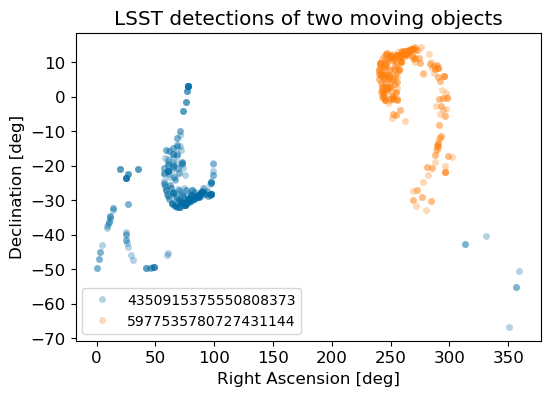

In [39]:
fig = plt.figure(figsize=(6, 4))
for uniqueId in uniqueIds:
    tx = results['ssObjectId'] == uniqueId
    plt.plot(results['ra'][tx], results['dec'][tx],
             'o', ms=5, alpha=0.3, mew=0, label=str(uniqueId))
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.title('LSST detections of two moving objects')
plt.legend(loc='lower left')
plt.show()

> Figure 2: Above, the coordinates of the LSST difference-image detections from the `diaSource` catalog for the two moving objects listed in the user-uploaded table.

Clean up.

In [40]:
del fnm2, ut2, query, job, results, uniqueIds, counts

## 4. Gaia data for DP0.3 asteroids

This section demonstrates how to do an external TAP query to retrieve a Gaia data table using `PyVO` from the RSP,
and then upload the table and use it in a joint query with the LSST DP0.3 catalogs.

Gaia data is also accessible via the [Gaia Archive](https://www.cosmos.esa.int/web/gaia-users/archive)
(see the Help tab for more information about Gaia catalogs and data access). 

### 4.1. Retrieve Gaia data for main-belt asteroids

Get an instance of the Gaia TAP service using `PyVO` and assert that it exists.

In [41]:
gaia_tap_url = 'https://gea.esac.esa.int/tap-server/tap'
gaia_tap = pyvo.dal.TAPService(gaia_tap_url)
assert gaia_tap is not None
assert gaia_tap.baseurl == gaia_tap_url

Query the Gaia database for main-belt asteroids (MBAs) following the population definition used by the
[JPL Horizons small body database query tool](https://ssd.jpl.nasa.gov/tools/sbdb_query.html):
2.0 < `a` < 3.25 au and `q` > 1.666 au.

To expedite the query, only return objects with more than 200 observations (i.e., well-observed objects),
and limit the number of objects returned to 1000 with `SELECT TOP 1000`.

In [69]:
gaia_query = """
             SELECT TOP 1000 denomination, inclination,
                 eccentricity, semi_major_axis
             FROM gaiadr3.sso_orbits
             WHERE num_observations > 200
             AND semi_major_axis > 2.0
             AND semi_major_axis < 3.2
             AND semi_major_axis*(1-eccentricity) > 1.666
             """

Run the query and retrieve the results.

In [70]:
gaia_job = gaia_tap.submit_job(gaia_query)
gaia_job.run()
gaia_job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', gaia_job.phase)

Job phase is COMPLETED


Retrieve the results and convert them to an `astropy` table with `to_table`, and then
to a `pandas` table with `to_pandas`, in order to enable some column reformatting.

In [71]:
gaia_results = gaia_job.fetch_result().to_table().to_pandas()
gaia_results

,denomination,inclination,eccentricity,semi_major_axis
0,2000_so179,0.058380,0.120836,2.701355
1,1999_gu8,0.113790,0.208611,2.203320
2,2000_ge143,0.185379,0.074487,3.091090
3,5082_t-3,0.097229,0.149435,2.313023
4,2000_su299,0.227229,0.075321,3.169976
...,...,...,...,...
995,2002_fz21,0.163673,0.151235,2.748965
996,1999_ty119,0.293903,0.127409,2.528548
997,2000_jo11,0.105113,0.070638,2.744648
998,2002_tx175,0.248212,0.035291,2.529221


#### 4.1.1. Plot the orbital parameters

To explore the retrieved data for 1000 MBAs, make plots showing eccentricity (`e`) and inclination (`i`) against semi-major axis (`a`).

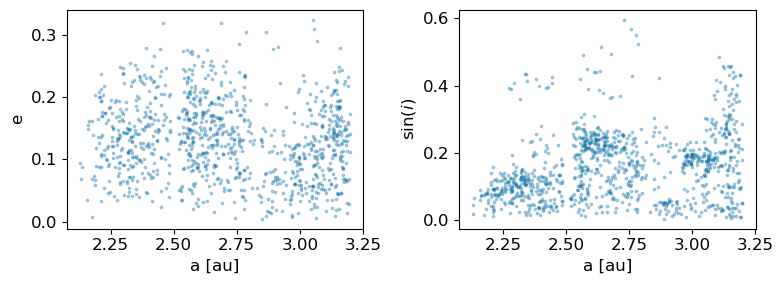

In [72]:
fig = plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(gaia_results['semi_major_axis'], gaia_results['eccentricity'],
            s=3, alpha=0.3)
plt.xlabel('a [au]')
plt.ylabel('e')
plt.subplot(122)
plt.scatter(gaia_results['semi_major_axis'], np.sin(gaia_results['inclination']),
            s=3, alpha=0.3)
plt.xlabel('a [au]')
plt.ylabel(r'sin($i$)')
plt.tight_layout()
plt.show()

> Figure 3: Above, scatter plots of the orbital parameters for 1000 MBAs from Gaia. At left, eccentricity (e) versus the semi-major axis (a). At right, inclination versus semi-major axis.

#### 4.1.2. Reformat the MPC designation column

The `MPCORB` table in DP0.3 follows the standard format for MPC designation, which is the year, then a space,
and then an identifier that is several characters, capital letters and numbers.
However, the `denomination` in some Gaia tables (like `sso_orbit`, queried above) uses underscores instead of spaces and/or lower-case letters instead of capital letters.

The `denomination` column needs to be converted to the standard MPC designation format (`mpc_desig1`)
in order to cross-match (table join) the Gaia data with the DP0.3 data in Section 4.2.2.
The `denomination` column also needs to be converted to use spaces instead of underscores,
but keep the lower-case letters (`mpc_desig2`), in order to identify a moving object by
name in the Gaia `sso_observation` table in Section 4.2.3.

In [73]:
gaia_results['mpc_desig1'] = gaia_results['denomination'].str.replace('_', ' ').str.upper()
gaia_results['mpc_desig2'] = gaia_results['denomination'].str.replace('_', ' ')
gaia_results

,denomination,inclination,eccentricity,semi_major_axis,mpc_desig1,mpc_desig2
0,2000_so179,0.058380,0.120836,2.701355,2000 SO179,2000 so179
1,1999_gu8,0.113790,0.208611,2.203320,1999 GU8,1999 gu8
2,2000_ge143,0.185379,0.074487,3.091090,2000 GE143,2000 ge143
3,5082_t-3,0.097229,0.149435,2.313023,5082 T-3,5082 t-3
4,2000_su299,0.227229,0.075321,3.169976,2000 SU299,2000 su299
...,...,...,...,...,...,...
995,2002_fz21,0.163673,0.151235,2.748965,2002 FZ21,2002 fz21
996,1999_ty119,0.293903,0.127409,2.528548,1999 TY119,1999 ty119
997,2000_jo11,0.105113,0.070638,2.744648,2000 JO11,2000 jo11
998,2002_tx175,0.248212,0.035291,2.529221,2002 TX175,2002 tx175


Save the result as a CSV (comma separated values) file in the home directory to explore an option of using pandas table joins in Section 5.

In [74]:
gaia_results.to_csv(my_home_dir+'gaia_mba.cat', index=False)

Clean up. Only `gaia_results` is needed for the next section.

In [ ]:
del gaia_tap_url, gaia_tap
del gaia_query, gaia_job

### 4.2. Gaia object cross-match to MPCORB and diaSources

The scientific scenario used for this demonstration is that for the 1000 Gaia moving objects,
the question is whether LSST detected them and, if so, what their $g$-band difference-image magnitudes
are for each detection.

#### 4.2.1. Reformat the table

As `gaia_results` is a `pandas` table, but the TAP service does not accept uploads in a Pandas `DataFrame` format,
convert it back to an `astropy` table using the imported `Table` method.
Follow the convention established in the sections above and name the table `ut3`.

In [47]:
ut3 = Table.from_pandas(gaia_results)
ut3.dtype

dtype([('denomination', '<U15'), ('inclination', '<f8'), ('eccentricity', '<f8'), ('semi_major_axis', '<f8'), ('mpc_desig1', '<U15'), ('mpc_desig2', '<U15')])

Notice that the `denomination` and `mpc_desig` columns are of data type (`dtype`) Unicode (`U`).
Uploading a table which includes Unicode columns will not work.
Convert the Unicode columns (`dtype.kind='U'`) to bytestring (`dtype.kind='S'`) using the
`convert_unicde_to_bytestring`.

In [48]:
ut3.convert_unicode_to_bytestring()

Clean up.

In [ ]:
del gaia_results

#### 4.2.2. Execute the query

Prepare a query to join three tables: the user-specified Gaia table data, the DP0.3 `MPCORB` table, and the DP0.3 `diaSource` table.

This query will return the magnitudes for all LSST detections in $g$-band difference images from the DP0.3 `diaSource` table
for all objects in the user-uploaded Gaia table data (where a match exists).

In the query, the first join between the Gaia user-uploaded table and the DP0.3 `MPCORB` table obtains the internal LSST `ssObjectId`
for a given moving object by joining on MPC designation.
The second join between the `MPCORB` table and the `diaSource` table obtains all $g$-band detections associated
with the `ssObjectId`.
This triple join is necessary because the `diaSource` table does not contain the MPC designation.

In [49]:
query = """
        SELECT mpc.mpcDesignation, mpc.ssObjectId,
        ut3.denomination, ut3.mpc_desig2,
        dias.midPointMjdTai, dias.mag, dias.band
        FROM dp03_catalogs_10yr.MPCORB AS mpc
        INNER JOIN TAP_UPLOAD.ut3 as ut3
        ON ut3.mpc_desig1 = mpc.mpcDesignation
        INNER JOIN dp03_catalogs_10yr.DiaSource as dias
        ON dias.ssObjectId = mpc.ssObjectId
        Where dias.band = 'g'
        """

Execute the query, then retrieve the results.

In [50]:
job = rsp_tap.submit_job(query, uploads={"ut3": ut3})
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [51]:
results = job.fetch_result().to_table()
results

mpcDesignation,ssObjectId,denomination,mpc_desig2,midPointMjdTai,mag,band
,,,,d,,
str8,int64,str15,str15,float64,float32,str1
1020 T-3,-942361610017462599,1020_t-3,1020 t-3,63562.16077,18.813,g
1020 T-3,-942361610017462599,1020_t-3,1020 t-3,63096.99067,21.002,g
1020 T-3,-942361610017462599,1020_t-3,1020 t-3,61470.26138,19.519,g
1020 T-3,-942361610017462599,1020_t-3,1020 t-3,62919.34252,20.99,g
1020 T-3,-942361610017462599,1020_t-3,1020 t-3,61993.09195,19.406,g
1020 T-3,-942361610017462599,1020_t-3,1020 t-3,63512.28129,18.624,g
1020 T-3,-942361610017462599,1020_t-3,1020 t-3,63559.12272,18.723,g
1020 T-3,-942361610017462599,1020_t-3,1020 t-3,62447.30256,20.195,g


Print the number of objects (out of the 1000 from Gaia) that were detected by LSST,
and also the minimum, maximum, and mean number of LSST detections over the ten-year survey.

In [52]:
uniqueIds, counts = np.unique(results['ssObjectId'], return_counts=True)
print('Number of LSST-detected objects: ', len(uniqueIds))
print('Minimum, maximum, and mean number of detections per object: ',
      np.min(counts), np.max(counts), int(np.mean(counts)))

Number of LSST-detected objects:  773
Minimum, maximum, and mean number of detections per object:  4 215 34


Clean up.

In [ ]:
del ut3, query, job
del uniqueIds, counts

#### 4.2.3. Plot the Gaia+LSST light curve for one MBA

Select one random MBA and save its data entry as a small table called `random_mba`.

In [53]:
uniqueObj = np.random.choice(results['ssObjectId'], 1)[0]
print('ssObjectId: ', uniqueObj)
random_mba = results[results['ssObjectId'] == uniqueObj]
print('MPC designation: ', random_mba['mpc_desig2'][0])

ssObjectId:  -8026419521491339565
MPC designation:  1999 cx110


Retrieve Gaia photometry for the selected MBA. 

Occasionally, the following error message may occur: 
```DALServiceError: 401 Client Error: 401 for url: https://gea.esac.esa.int/tap-server/tap/sync```.
This usually represents an intermittent service error.
To avoid it, rerun the following cell.

In [54]:
gaia_tap_url = 'https://gea.esac.esa.int/tap-server/tap'
gaia_tap = pyvo.dal.TAPService(gaia_tap_url)
assert gaia_tap is not None
assert gaia_tap.baseurl == gaia_tap_url

Define and execute a query to retrieve the dates (`epoch_utc`) and $g$-band magnitudes (`g_mag`)
of Gaia observations for the randomly selected MBA by only returning rows
where the `denomination` is equal to `mpc_desig2`, which is the MPC
Designation reformatted to the convention of the Gaia `sso_observation` table
(see Section 4.1.2).

In [55]:
gaia_query = """
             SELECT epoch_utc, g_mag
             FROM gaiadr3.sso_observation
             WHERE denomination = '{}'
             """.format(random_mba['mpc_desig2'][0])
gaia_job = gaia_tap.submit_job(gaia_query)
gaia_job.run()
gaia_job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', gaia_job.phase)

Job phase is COMPLETED


Retrieve the results.

In [56]:
gaia_results = gaia_job.fetch_result().to_table()

Convert Universal Time Coordinated (UTC) observation date (`epoch_utc`) to a Modified Julian Date (MJD) observation date.

From the [Gaia documentation](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_sso_tables/ssec_dm_sso_observation.html), `epoch_utc` is the Gaiacentric epoch UTC, while the LSST records observing time in MJD. The conversion is MJD = UTC + 55197.5 (day).

In [57]:
gaia_results['epoch_mjd'] = gaia_results['epoch_utc'] + 55197.5

Plot the $g$-band light curve for the selected asteroid.

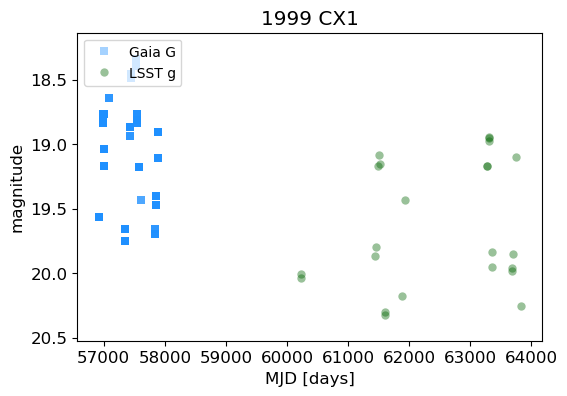

In [65]:
fig = plt.figure(figsize=(6, 4))
plt.plot(gaia_results['epoch_mjd'], gaia_results['g_mag'],
         's', alpha=0.4, mew=0, color='dodgerblue', label='Gaia G')
plt.plot(random_mba['midPointMjdTai'], random_mba['mag'],
         'o', alpha=0.4, mew=0, color='darkgreen', label='LSST g')
ymin = min(gaia_results['g_mag'].min(), random_mba['mag'].min())
ymax = max(gaia_results['g_mag'].max(), random_mba['mag'].max())
plt.ylim(ymax+0.2, ymin-0.2)
plt.legend(loc='upper left')
plt.xlabel('MJD [days]')
plt.ylabel('magnitude')
plt.title(random_mba['mpcDesignation'][0])
plt.show()

> Figure 4: Above, the Gaia G-band detections in cyan squares and the simulated DP0.3 LSST $g$-band magnitudes in green circles as a function of time. The variation in apparent magnitude over time is primarily due to the object's changing distance from Earth.

Clean up.

In [ ]:
del results, uniqueObj, random_mba
del gaia_tap_url, gaia_tap, gaia_query, gaia_job, gaia_results

### 4.3. Gaia object cross-match to MPCORB using the `merge` method provided by `pandas`

The scientific scenario used for this demonstration is for a user-created `pandas` table 
of moving objects (recycle the saved 1,000 Gaia MBA data as an example), whether LSST detected
them during a given range of MJD observation dates. The LSST query result will be also saved
as a `pandas` table, and the join with the user-created table will be done using the `merge` function. 

#### 4.3.1. Read the Gaia MBA table as a Pandas `DataFrame`.

## 6. Excercises for the learner

1. In Section 4.1, the Gaia database was queried for main-belt asteroids (MBAs) following the
population definition used by the [JPL Horizons small body database query tool](https://ssd.jpl.nasa.gov/tools/sbdb_query.html).
At that link, click on "Limit by Orbit Class" and then hover the cursor over any "information" symbol
to see any definition. Use the definition of TransNeptunian Object (TNO) to rewrite the query in Section 4.1
and create a table of the nine Gaia objects with >200 observations and the semi-major axis of a TNO.
Clear the kernel and re-execute the notebook in full, using Gaia TNOs instead of MBAs; there
should be 4 detected by LSST.

2. (Advanced) Generate a table of DP0.3 objects of interest and save it as a file (e.g., the MPC designations of TNOs identified in step 1). Using Sections 3 and 4 as a guide, use the user-upload functionality and do a tripe-table join with the DP0.3 `SSObject` catalog (match on MPC designation)
and `SSSource` catalog (match on `ssObjectId`) to obtain and plot, e.g., heliocentric distances.